# Applying Recurrent Neural Network to predict the stock price

---
This notebook represents the prediction of 'Closing' stock price of Apple using time series analysis method. The purpose of the assignment is to understanding Recurrent Neural Network and how to build a Machine Learning model using Tensorflow framework. The assignment will focus on univariate time series forecasting.

The notebook need to install two libraries that are Tensorflow 2.2.0 and Yfinance. 

*   In Tensorflow, we use Keras library to build and train a model.
*   Yfinance is used to get a stock dataset of a company from Yahoo's API.

<br> The commands below will install two libraries if they did not exist on a machine. If the machine doesn't have pip package manager, please refer to [this link ](https://pip.pypa.io/en/stable/installing/) to install pip before executing the commands.

In [0]:
!pip install tensorflow==2.2.0
!pip install yfinance

In [0]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


Initialize a dataframe of Apple stock history since it published. This analysis only use a univariate series. We choose a series of Closing price.

In [0]:
apple = yf.Ticker("AAPL")
apple = apple.history(period="max")
apple = apple[['Close']]
apple.shape

(9938, 1)

We normalize the dataset which all data converts into the numbers in range(0,1) so we can improve the network converges when starting training a model.

In [0]:
normalize_scaler = MinMaxScaler()
normalized_dataset = normalize_scaler.fit_transform(apple)

We will predict the price of next value based on previous values of a chunk so we create a function to slice the dataset into chunks. 

<br>Since the dataset is a time series, there might occur sequence bias which make the model less accuracy in prediction. Additionally, it has a chance of overfitting because the model has well training on window dataset in the training series. We decide to shuffle the dataset to increase convergence in training. To improve performance and execution time while training a model, we split the into small batches and use prefetch function in Tensorflow.data API. It means as the model is executing the training on one step, the input pipeline is loading the data for next.


In [0]:
def window_dataset(series, window_size, batch_size, shuffle_size):
    """ Function will slice the series dataset into 
        small lists of item have a size of window_size argument.                        
        
        Return the dataset with lists of tuples of 2 which has
        first element is a list of item except the last,
        second element is last element.
    """
    # series = tf.expand_dims(series, axis=-1) #reshape the dataset to fit LSTM model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda ds : ds.batch(window_size + 1))
    ds = ds.shuffle(shuffle_size)
    ds = ds.map(lambda ds: (ds[:-1], ds[-1:]))
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

We learned if we can split the dataset into small batches while training a model can affect the learning speed as well as the learning accuracy regarding to this Youtube [video](https://www.youtube.com/watch?v=4qJaSmvhxi8). We will use this as a hyperparameter to train our neural network model. 
<br>For this assignment we will predict the each next day by using data from previous 60 days of its.

In [0]:
window_size = 60
batch_size = 128
shuffle_size = 500

Setting the size for training set and test set.

In [0]:
split_ratio = 0.8
train_size = int(split_ratio * len(normalized_dataset))
valid_size = int(len(normalized_dataset) - train_size)

In [0]:
x_train = normalized_dataset[:train_size]
x_valid = normalized_dataset[train_size:]

Create a function to predict the next value of each averaging window period after model has been trained.

In [0]:
def model_forecast(model, series, window_size):
    """ Function will split the dataset into small chunks have size of window_size.
        The model after training will predict the next value of each chunk.

        Return the dataset which includes the next predicted value of each window period
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Implementation of Recurrent Neural Network(RNN)



Initialize Keras's modules to use for buidling RNN model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Conv1D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber

The model will a Simple Recurrent Neural Network with 31 neurons unit for each layers. There have 4 layers in total. First layers will return entire sequence of output at once. We add a set of dense output as hidden layers for RNN output. Then last one will another single dense output layer for the result.

<br> To improve execution for the model, we apply Stochastic Gradient Descent(SGD) as an optimizer since SGD will cacluate the errors and update to the parameters frequenty. Therefore, the model is able to converge faster. 

<br> For loss function we use Mean Absolute Error(MAE) to reduce the outliner result compare Mean Square Error(MSE).

In [0]:
# Number of units in RNN layer
rnn_units = 31

# This variable is Verbosity mode when executes model training (0 = silent, 1 = progress bar)
verbose_mode = 0

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#Process the training dataset into the batches in the range of 60 days
train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, 
                              input_shape=[None,1]), 
    tf.keras.layers.Dense(31),
    tf.keras.layers.Dense(1), #output a single dense    
])

optimizer_SGD = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9) 

model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=optimizer_SGD,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, verbose=verbose_mode) 

Epoch 1/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0138 - mae: 0.0138
Epoch 2/100
62/62 [==============================] - 2s 40ms/step - loss: 0.0141 - mae: 0.0141
Epoch 3/100
62/62 [==============================] - 3s 43ms/step - loss: 0.0140 - mae: 0.0140
Epoch 4/100
62/62 [==============================] - 3s 41ms/step - loss: 0.0140 - mae: 0.0140
Epoch 5/100
62/62 [==============================] - 3s 41ms/step - loss: 0.0139 - mae: 0.0139
Epoch 6/100
62/62 [==============================] - 3s 41ms/step - loss: 0.0139 - mae: 0.0139
Epoch 7/100
62/62 [==============================] - 2s 40ms/step - loss: 0.0139 - mae: 0.0139
Epoch 8/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0138 - mae: 0.0138
Epoch 9/100
62/62 [==============================] - 3s 41ms/step - loss: 0.0138 - mae: 0.0138
Epoch 10/100
62/62 [==============================] - 3s 41ms/step - loss: 0.0138 - mae: 0.0138
Epoch 11/100
62/62 [=============================

### Prediction

Predict the next values of previous 60-day period. rnn_forecast is dataset included the predicted values is used to compare to actual values of validation dataset.

In [0]:
ds_forecast = model_forecast(model, normalized_dataset, window_size)
rnn_forecast = ds_forecast[train_size - window_size:-1,-1]

#### Result

As we can see from the chart, the forecasting graph is really noisy. The trend of forecasting values is really off compare to the actual values. Since we use Mean Absolute Error to evaluate the loss, the gradient is the same throughout training. Therefore, gradient is really large even for small loss values.

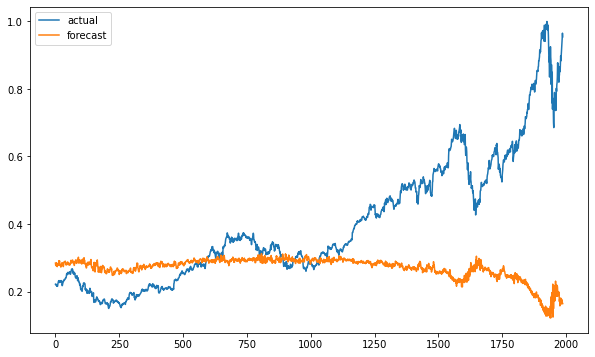

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(x_valid, label='actual')
plt.plot(rnn_forecast, label='forecast')
plt.legend()

This absolute error is based value used to evaluate the model after we tune the model. From the above graph we can see the accuracy is very large we rescale back the normalized values to original values.

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], rnn_forecast[:,0]).numpy()

0.16902734

Plot the loss after 100 epochs

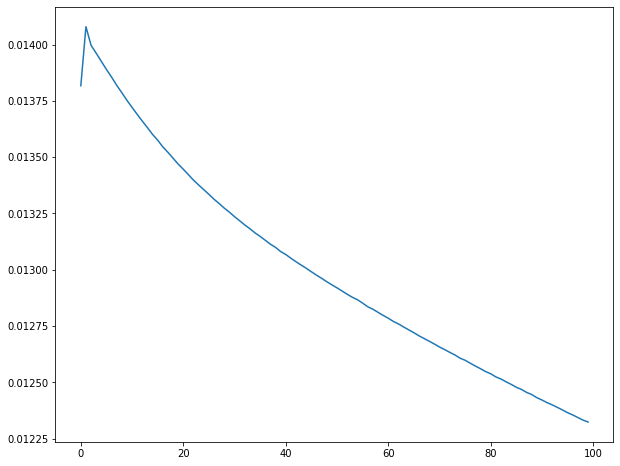

In [0]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])

Enlarge the above graph from epoch 80 to 100

(80.0, 100.0, 0.01225, 0.013)

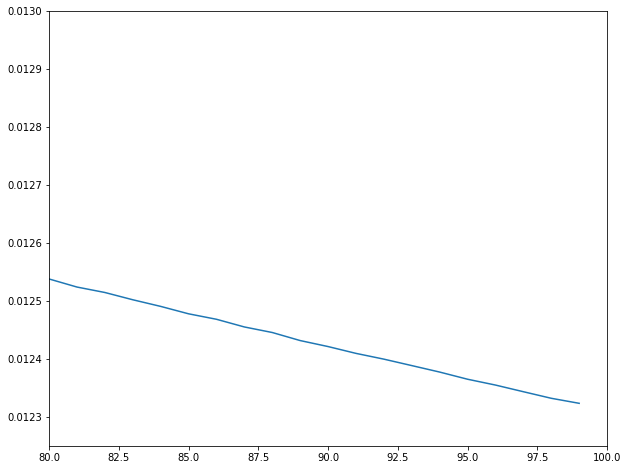

In [0]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.axis([80,100, 0.01225, 0.01300])

From two graphs above we can see the model has improved and the loss descreased when the training time went up to 100 epochs. We will increase the training time to see if it will help improve the gradient and reduce the loss.

## Tuning the model - first time

Using a callback scheduler to narrow down the range of learing rate to identify good learning rate for model. We use Huber as a loss function because it decreases the gradient while using Mean Absolute Error and less sensitive to outliner data then Mean Squar Error. 

</br> In addition, we add Rectified Unit as the output activation function. Since stock price will never have negative values, all negative values will become zeros. 

Reference [Huber loss](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, 
                              input_shape=[None,1]), 
    tf.keras.layers.Dense(31, activation='relu'),
    tf.keras.layers.Dense(1), #output a single dense    
])

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/20)
)

optimizer_SGD = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9, verbose=verbose_mode) 

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_SGD,
              metrics=["mae"])

history = model.fit(train_set, epochs=120, callbacks=[lr_callbacks]) 

Epoch 1/120
62/62 [==============================] - 2s 40ms/step - loss: 6.7292e-04 - mae: 0.0143 - lr: 1.0000e-07
Epoch 2/120
62/62 [==============================] - 3s 41ms/step - loss: 6.7278e-04 - mae: 0.0143 - lr: 1.1220e-07
Epoch 3/120
62/62 [==============================] - 2s 40ms/step - loss: 6.7262e-04 - mae: 0.0143 - lr: 1.2589e-07
Epoch 4/120
62/62 [==============================] - 3s 42ms/step - loss: 6.7244e-04 - mae: 0.0143 - lr: 1.4125e-07
Epoch 5/120
62/62 [==============================] - 2s 40ms/step - loss: 6.7225e-04 - mae: 0.0143 - lr: 1.5849e-07
Epoch 6/120
62/62 [==============================] - 3s 41ms/step - loss: 6.7202e-04 - mae: 0.0143 - lr: 1.7783e-07
Epoch 7/120
62/62 [==============================] - 3s 40ms/step - loss: 6.7178e-04 - mae: 0.0143 - lr: 1.9953e-07
Epoch 8/120
62/62 [==============================] - 3s 41ms/step - loss: 6.7150e-04 - mae: 0.0143 - lr: 2.2387e-07
Epoch 9/120
62/62 [==============================] - 3s 41ms/step - loss

### Prediction

Predict the next values of previous 60-day period. rnn_forecast is dataset included the predicted values is used to compare to actual values of validation dataset.

In [0]:
ds_forecast = model_forecast(model, normalized_dataset, window_size)
rnn_forecast = ds_forecast[train_size - window_size:-1,-1]

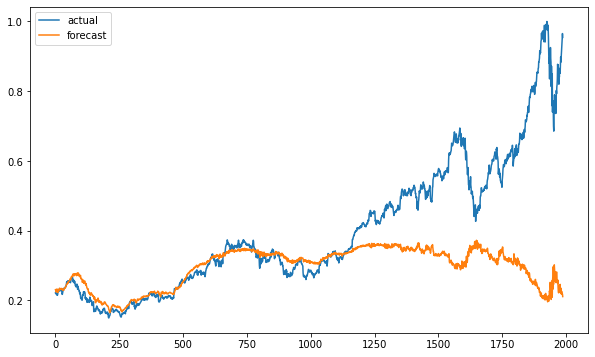

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(x_valid, label='actual')
plt.plot(rnn_forecast, label='forecast')
plt.legend()

#### Result

As we can see from the chart, the forecasting graph is improved, albeit it still has some noisy. In the first part of graph above, we're also able to see the forecasting graph has picked up the trend of the actual graph.

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], rnn_forecast[:,0]).numpy()

0.120264664

Compare to first training, the model has an improvement after we increase the number of training time and adding Relu activation for output dense.

| Error Metric| Previous    | Current       |
| :---        |    :----:   |          ---: |
| MAE         | 0.169       | 0.12026       |

Plot the test accuracy to see where we can find a good learning rate for next training. An optimal learning rate can improve the convergence of the model.

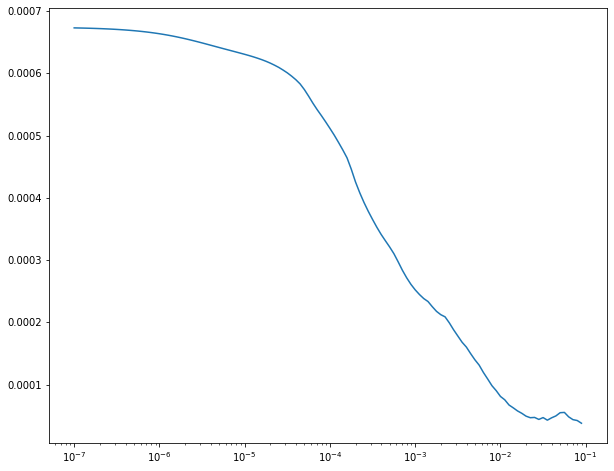

In [0]:
plt.figure(figsize=(10,8))
plt.semilogx(history.history['lr'], history.history['loss'])

Enlarge the graph to learning rate between <math>$5*10^{-3}$ and $10^{-1}$ </math>

(0.005, 0.1, 0.0, 0.0002)

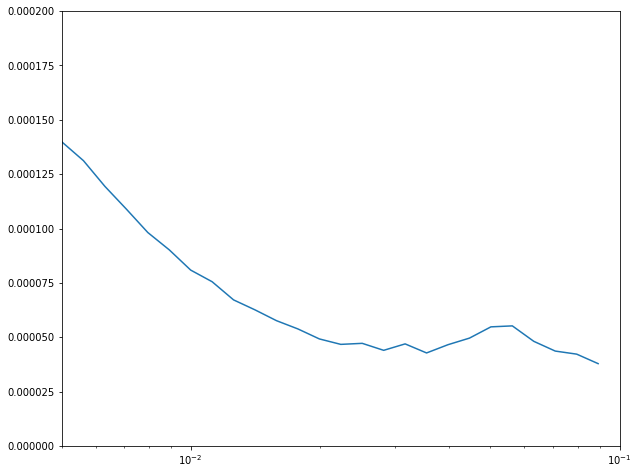

In [0]:
plt.figure(figsize=(10,8))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([5e-3, 1e-1, 0, 0.0002])

As we can see the learning rate looks pretty good between <math>$5*10^{-3}$</math> and approximate <math>$10^{-1}$</math>. Regarding to Stochastic Gradient Descent algorithm, when the timesteps increase, the slope will reach to the lowest point where we can achieve an optimal learning rate. We will pick next learning rate is <math>$4*10^{-2}$</math>.

<br>We also found a picture to help us visualizing the pattern of learning rate.

![alt text](https://miro.medium.com/max/918/0*C5kIkoBwht0fXRgs.jpeg)

## Tuning the model - second time

Regarding to the results of learning rate from the graphs above, we will select <math>$4*10^{-2}$</math> as a learning rate for this training.

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, 
                              input_shape=[None,1]), 
    tf.keras.layers.Dense(31, activation='relu'),
    tf.keras.layers.Dense(1), #output a single dense    
])

optimizer_SGD = tf.keras.optimizers.SGD(lr=4e-2, momentum=0.9, verbose=verbose_mode) 


model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_SGD,
              metrics=["mae"])

history = model.fit(train_set, epochs=100) 

Epoch 1/100
62/62 [==============================] - 3s 41ms/step - loss: 2.2343e-04 - mae: 0.0081
Epoch 2/100
62/62 [==============================] - 2s 40ms/step - loss: 6.3041e-04 - mae: 0.0243
Epoch 3/100
62/62 [==============================] - 3s 41ms/step - loss: 3.9617e-04 - mae: 0.0185
Epoch 4/100
62/62 [==============================] - 3s 40ms/step - loss: 4.6218e-04 - mae: 0.0220
Epoch 5/100
62/62 [==============================] - 2s 40ms/step - loss: 3.9513e-04 - mae: 0.0204
Epoch 6/100
62/62 [==============================] - 3s 42ms/step - loss: 2.8907e-04 - mae: 0.0175
Epoch 7/100
62/62 [==============================] - 3s 40ms/step - loss: 2.4178e-04 - mae: 0.0161
Epoch 8/100
62/62 [==============================] - 3s 40ms/step - loss: 1.8394e-04 - mae: 0.0141
Epoch 9/100
62/62 [==============================] - 3s 40ms/step - loss: 1.6058e-04 - mae: 0.0132
Epoch 10/100
62/62 [==============================] - 2s 40ms/step - loss: 1.3432e-04 - mae: 0.0120
Epoch 11/

#### Result

Compute MAE between predicted dataset and validation set after the model has been trained.

In [0]:
ds_forecast = model_forecast(model, normalized_dataset, window_size)
rnn_forecast = ds_forecast[train_size - window_size:-1,-1]
tf.keras.metrics.mean_absolute_error(x_valid[:,0], rnn_forecast[:,0]).numpy()

0.10805943

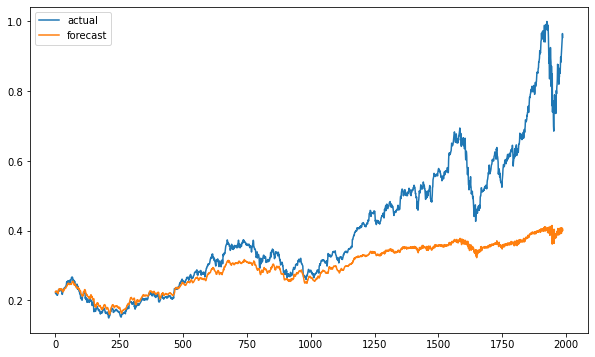

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(x_valid, label='actual')
plt.plot(rnn_forecast, label='forecast')
plt.legend()

## Conculsion

As we can see from the result of MAE and the chart after the training, the model is getting better. The MAE reduced from 0.120264 to 0.108059. Since Simple Neural Network doesn't remember the input of previous steps, it might lost some information on predicting next steps. In addition, after many attempts we understand that choosing a proper learning rate can also imrpove on the model.